In [176]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from functions.naming import rename_columns
import tensorflow as tf

# Assuming your data is in a pandas DataFrame named 'df' with a datetime index
# and a column named 'monthly_data'
# Replace this with your actual data loading process
# For simplicity, I'll create a dummy dataset
# Load the data
df = pd.read_excel("/Users/athanasioskaravangelis/Desktop/RSM BAM/Workshop/pko_forecasting/data/PKO_Initial_Dataset.xlsx")
#rename columns
df = rename_columns(df)
# select only the values after 2010-01-01
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df = df[df['date'] > '2009-12-02']

# Ensure the date column is the index
df.set_index('date', inplace=True)

# Specify columns to exclude
exclude_columns = [
    'pko_total_supply_malaysia', 'indonesia_disaster', 'malaysia_disaster',
    'pko_fob_malaysia', 'jet_fuel_us', 'jet_fuel_europe', 'soybean_oil_zlz2',
    'tallow_fob_us_gulf', 'bio_ethanol', 'rspo', 'palm_oil_cif_nwe', 'palm_olein_fob_malaysia',
    'palm_stearin_cif_rotterdam', 'fatty_alcohol_c12_14_fob_asia', 'fatty_alcohol_c16_18_fob_asia',
    'fatty_alcohol_c12_14_fd_nwe', 'jet_fuel_us_usd_mt'
]

# Filter the dataset to exclude specified columns
df_filtered = df.drop(columns=exclude_columns)

# Update NUM_FEATURES based on the filtered dataset
num_features = df_filtered.shape[1]
num_features

# fill nas with average values
df = df_filtered.fillna(df_filtered.mean())

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences for the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [178]:
# Choose sequence length and split data into train and test sets
seq_length = 12
train_size = int(len(df_scaled)*0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

# Create sequences for training
X_train, y_train = create_sequences(train_data, seq_length)
X_train.shape

(121, 12, 35)

In [179]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')  # You can experiment with different optimizers and loss functions

In [180]:
# Create sequences for testing
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input data for GRU model
print((X_test.shape[0], X_test.shape[1]))

# Train the model on the training set
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

(22, 12)
Epoch 1/100
4/4 [==============================] - 2s 172ms/step - loss: 0.6018 - val_loss: 0.2136
Epoch 2/100
4/4 [==============================] - 0s 41ms/step - loss: 0.1179 - val_loss: 0.1097
Epoch 3/100
4/4 [==============================] - 0s 37ms/step - loss: 0.1205 - val_loss: 0.1622
Epoch 4/100
4/4 [==============================] - 0s 37ms/step - loss: 0.1422 - val_loss: 0.1278
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.1010 - val_loss: 0.0987
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0805 - val_loss: 0.1002
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0841 - val_loss: 0.1071
Epoch 8/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0876 - val_loss: 0.1051
Epoch 9/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0839 - val_loss: 0.0994
Epoch 10/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0797 - val_loss: 0.0968
Epoch 11/

In [181]:
# Make predictions on the test set
y_pred = model.predict(X_test, batch_size=1)
y_pred

22/22 [==============================] - 0s 4ms/step


array([[0.53632975],
       [0.50947994],
       [0.5038497 ],
       [0.4938377 ],
       [0.49050006],
       [0.47116435],
       [0.47639552],
       [0.4848802 ],
       [0.48611698],
       [0.49724096],
       [0.48364517],
       [0.46973673],
       [0.42323425],
       [0.42866394],
       [0.4308681 ],
       [0.42377222],
       [0.43295652],
       [0.40496522],
       [0.4338379 ],
       [0.44087538],
       [0.44882184],
       [0.47814414]], dtype=float32)

In [182]:
# Reshape y_pred to 2D array
#y_pred_2d = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

y_pred_final = y_pred.reshape((y_pred.shape[0], 1))

# Inverse transform the predictions and true values
#y_pred_inverse = scaler.inverse_transform(y_pred_final)
y_pred_inverse = scaler.inverse_transform(np.hstack((y_pred_final, X_test[:, -1, 1:])))

y_test_inverse = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test_inverse - y_pred_inverse)**2))
print('Root Mean Squared Error (RMSE):', rmse)
# calculate MAE
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print('Mean Absolute Error (MAE):', mae)
# calculate MSLE 
msle = np.mean(np.square(np.log(y_test_inverse + 1) - np.log(y_pred_inverse + 1)))
print('Mean Squared Log Error (MSLE):', msle)

Root Mean Squared Error (RMSE): 94.14345634513964
Mean Absolute Error (MAE): 27.99572063813281
Mean Squared Log Error (MSLE): nan


/var/folders/35/tbpcvh252s9dy7dhvwv499800000gn/T/ipykernel_2213/880767012.py:19: RuntimeWarning: divide by zero encountered in log
  msle = np.mean(np.square(np.log(y_test_inverse + 1) - np.log(y_pred_inverse + 1)))
/var/folders/35/tbpcvh252s9dy7dhvwv499800000gn/T/ipykernel_2213/880767012.py:19: RuntimeWarning: invalid value encountered in log
  msle = np.mean(np.square(np.log(y_test_inverse + 1) - np.log(y_pred_inverse + 1)))


In [168]:
y_test_inverse

array([[-9.00000000e-01,  4.37401000e-01,  4.19090000e-01,
         2.22610800e+01,  2.27631300e+01,  3.09013300e+01,
         3.21823700e+01,  3.55624300e+01,  3.69028600e+01,
         2.42500000e+03,  2.14600000e+03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.38716000e-01,
         6.96720000e-05,  1.35000000e+04,  3.95515054e+03,
         3.74000000e+02,  5.50000000e+03,  1.13746200e+03,
         1.26669000e+02,  3.69766800e+02,  2.63040000e+02,
         2.27164790e+02,  5.62310000e+01,  5.53017408e+01,
         5.67200000e+01,  1.50214451e+02,  5.12000000e+01,
         5.09000000e+01,  1.55000000e+02,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-1.00000000e+00,  3.83739000e-01,  3.65890000e-01,
         2.25350700e+01,  2.32165500e+01,  3.14088400e+01,
         3.27464400e+01,  3.63830000e+01,  3.81611600e+01,
         2.37800000e+03,  2.27100000e+03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.37974000e-01,
         6.97

In [183]:
y_pred_inverse [:,9]

array([2171., 2425., 2378., 2037., 1790., 1512., 1265., 1217., 1219.,
       1018., 1065., 1073., 1041., 1039., 1040., 1008.,  974.,  915.,
        978.,  993.,  945.,  906.])

In [184]:
df_results = pd.DataFrame()
df_results['date'] = df.index[train_size+seq_length:]
df_results['true_value'] = y_test_inverse[:, 9]
df_results['predicted_value'] = y_pred_inverse[:, 9]
df_results['difference'] = df_results['true_value'] - df_results['predicted_value']
df_results

,date,true_value,predicted_value,difference
0,2022-02-01,2425.0,2171.0,254.0
1,2022-03-01,2378.0,2425.0,-47.0
2,2022-04-01,2037.0,2378.0,-341.0
3,2022-05-01,1790.0,2037.0,-247.0
4,2022-06-01,1512.0,1790.0,-278.0
5,2022-07-01,1265.0,1512.0,-247.0
6,2022-08-01,1217.0,1265.0,-48.0
7,2022-09-01,1219.0,1217.0,2.0
8,2022-10-01,1018.0,1219.0,-201.0
9,2022-11-01,1065.0,1018.0,47.0


In [185]:
# Forecasting - predicting 12 months into the future
last_sequence = X_test[-1]
forecast = []

for i in range(12):
    # Prediction using the trained model
    prediction = model.predict(np.reshape(last_sequence, (1, seq_length, X_train.shape[2])))
    
    # Append the prediction to the forecast list
    forecast.append(prediction[0, 0])
    
    # Update the last sequence for the next iteration
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[:, -1, 0] = prediction[0, 0]  # Corrected line for updating the last sequence

# Inverse transform the forecasted values to get the actual values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]
forecast_df = pd.DataFrame({'forecasted_data': forecast.flatten()}, index=forecast_dates)

# Print or visualize the forecasted data
print(forecast_df)


1/1 [==============================] - 0s 309ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [175]:
# Forecasting - predicting 12 months into the future
last_sequence = X_test[-1]
forecast = []

for i in range(12):
    prediction = model.predict(np.reshape(last_sequence, (1, seq_length, 1)))
    forecast.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[:, -1] = prediction[0, 0]  # Corrected line

# Inverse transform the forecasted values to get the actual values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]
forecast_df = pd.DataFrame({'forecasted_data': forecast.flatten()}, index=forecast_dates)

# Print or visualize the forecasted data
print(forecast_df)


ValueError: cannot reshape array of size 420 into shape (1,12,1)

<Figure size 1000x600 with 0 Axes>

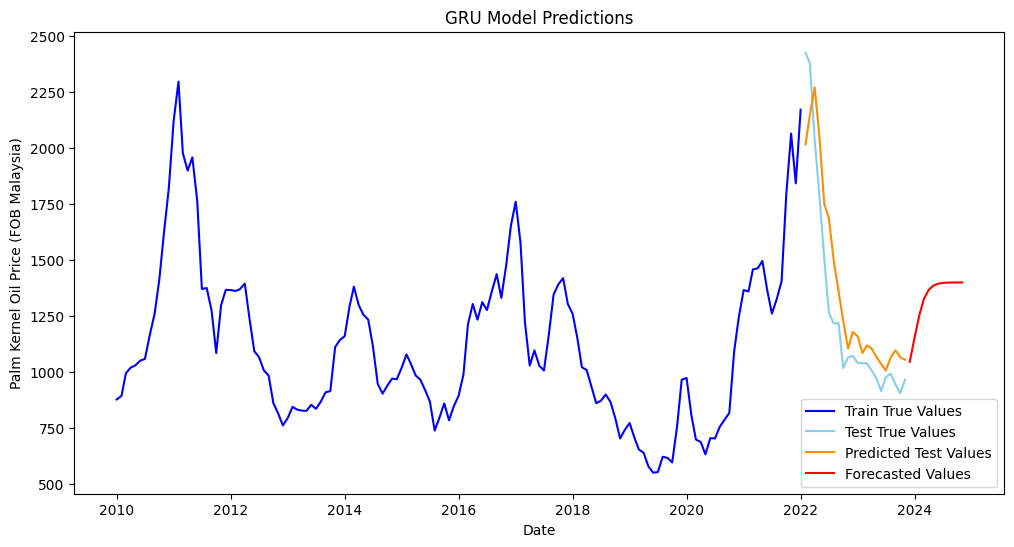

In [171]:
# now plot the true values of the train and test set and then the future predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.figure(figsize=(12, 6))
plt.plot(df.index[:train_size+seq_length], df['pko_cif_rotterdam'][:train_size+seq_length], label='Train True Values', color='blue')
plt.plot(df.index[train_size+seq_length:], df['pko_cif_rotterdam'][train_size+seq_length:], label='Test True Values', color='skyblue')
# also plot the predicted test values
plt.plot(df_results['date'], df_results['predicted_value'], label='Predicted Test Values', color='darkorange')
plt.plot(forecast_df.index, forecast_df['forecasted_data'], label='Forecasted Values', color='red')
plt.title('GRU Model Predictions')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
plt.legend()
plt.show()